# Анализ данных о транзакциях, связанных с подключениями и отключениями тарифных планов абонентами, которые меняли тарифные планы в первом полугодии 2017 года

<br>Необходимо исследовать следующие вопросы:
<br>1. Направления смен тарифных планов: с каких тарифных планов и на какие шли  наибольшие перетоки? 
<br>2. Насколько изменился среднемесячный счет абонентов за период 3 месяца после месяца смены тарифного плана в сравнении с периодом 3 месяца до месяца смены тарифного плана. Какие направления смен тарифных планов характеризовались ростом среднего счета в трехмесячном периоде, а какие – сокращением. 
<br>3. Аналогично п.2, только относительно изменения уровня блокировок: насколько реже или чаще стали попадать в блокировки абоненты после миграции в целом и для каждого направления миграции в отдельности. Для сравнения использовать те же периоды: 3 месяца до месяца смены плана и 3 месяца после месяца смены.

In [1]:
import pandas as pd
from io import BytesIO
import requests
from urllib.parse import urlencode
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import datetime

Импортируем полученные данные для анализа.

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

In [3]:
public_key = 'https://disk.yandex.by/d/4pVIAD6Ge2Xs3Q'  # Сюда вписываю мою ссылку
# Получаю загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
# Загружаю файл и сохраняю его
r = requests.get(download_url)
data_1 = r.content
tariff_plans_change = pd.read_csv(BytesIO(data_1))
tariff_plans_change.head()

,SUBSCRIBER_ID,TARIFF_PLAN_ID,START_DTTM,END_DTTM
0,1,2,2013-11-22 21:10:08,2017-03-11 14:24:17
1,1,3,2017-03-11 14:24:18,$null$
2,2,1,2016-02-05 16:36:34,2017-06-29 12:39:58
3,2,5,2017-06-29 12:39:59,$null$
4,3,1,2015-05-06 19:17:46,2017-04-14 12:00:59


Ввиду того, что задание выполняется спустя некоторое время после окончания периода предоставленных данных, установим NOW дату = 01.07.2017, т.к. данные предоставлены за первое полугодие 2017 года.

In [4]:
NOW = '2017-07-01'
NOW

'2017-07-01'

In [5]:
# проверим типы данных
tariff_plans_change.dtypes

SUBSCRIBER_ID      int64
TARIFF_PLAN_ID     int64
START_DTTM        object
END_DTTM          object
dtype: object

In [6]:
tariff_plans_change.isnull().sum()

SUBSCRIBER_ID     0
TARIFF_PLAN_ID    0
START_DTTM        0
END_DTTM          0
dtype: int64

Известно, значение $null$ означает, что план актуален на текущий момент, значение с типом данных object. 
А нам нужно конвертировать данные в дату. Поэтому заменим это значение на текущую дату NOW, которая была определена ранее.

In [7]:
tariff_plans_change.END_DTTM = [NOW if x == '$null$' else x for x in tariff_plans_change.END_DTTM]

In [8]:
tariff_plans_change.isnull().sum()

SUBSCRIBER_ID     0
TARIFF_PLAN_ID    0
START_DTTM        0
END_DTTM          0
dtype: int64

In [9]:
#конвертирую данные в дату, где необходимо 
tariff_plans_change['START_DTTM'] = pd.to_datetime(tariff_plans_change.START_DTTM).dt.normalize()
tariff_plans_change['END_DTTM'] = pd.to_datetime(tariff_plans_change.END_DTTM).dt.normalize()

In [10]:
public_key_2 = 'https://disk.yandex.by/d/9raRmViGBcmOCA'  # Сюда вписываю мою ссылку
# Получаю загрузочную ссылку
final_url_2 = base_url + urlencode(dict(public_key=public_key_2))
response_2 = requests.get(final_url_2)
download_url_2 = response_2.json()['href']
# Загружаю файл и сохраняю его
r2 = requests.get(download_url_2)
data_2 = r2.content
charges = pd.read_csv(BytesIO(data_2))
charges.head()

,SUBSCRIBER_ID,BILL_MONTH,CHARGES
0,4741,2017-03-01,4.572
1,1754,2017-05-01,4.894
2,381,2017-01-01,6.670
3,5832,2016-12-01,4.299
4,5277,2017-03-01,1.610


In [11]:
# проверим типы данных
charges.dtypes

SUBSCRIBER_ID      int64
BILL_MONTH        object
CHARGES          float64
dtype: object

In [12]:
#конвертирую данные в дату, где необходимо 
charges['BILL_MONTH'] = pd.to_datetime(charges.BILL_MONTH).dt.normalize()

In [13]:
charges.isnull().sum()

SUBSCRIBER_ID    0
BILL_MONTH       0
CHARGES          0
dtype: int64

In [14]:
public_key_3 = 'https://disk.yandex.by/d/l3btLoB6nxmHvA'  # Сюда вписываю мою ссылку
# Получаю загрузочную ссылку
final_url_3 = base_url + urlencode(dict(public_key=public_key_3))
response_3 = requests.get(final_url_3)
download_url_3 = response_3.json()['href']
# Загружаю файл и сохраняю его
r3 = requests.get(download_url_3)
data_3 = r3.content
suspended = pd.read_csv(BytesIO(data_3))
suspended.head()

,SUBSCRIBER_ID,START_DT,END_DT,STATUS
0,5195,2017-12-27,2017-12-27,Suspended
1,5198,2017-04-18,2017-04-18,Suspended
2,381,2017-04-18,2017-04-20,Suspended
3,3500,2017-12-21,$null$,Suspended
4,3302,2016-08-23,2016-09-07,Suspended


In [15]:
# проверим типы данных
suspended.dtypes

SUBSCRIBER_ID     int64
START_DT         object
END_DT           object
STATUS           object
dtype: object

In [16]:
# заменим значение null на текущую дату NOW, которая была определена ранее.
suspended.END_DT = [NOW if x == '$null$' else x for x in suspended.END_DT]

In [17]:
#конвертирую данные в дату, где необходимо 
suspended['START_DT'] = pd.to_datetime(suspended.START_DT).dt.normalize()
suspended['END_DT'] = pd.to_datetime(suspended.END_DT).dt.normalize()

In [18]:
# проверим данные на пропущенные значения
suspended.isna().sum()

SUBSCRIBER_ID    0
START_DT         0
END_DT           0
STATUS           0
dtype: int64

# Направления смен тарифных планов: с каких тарифных планов и на какие шли наибольшие перетоки? 
Визуализировать потоки миграций на диаграмме. 

Для дальнейших расчетов приведем данные по дате подключения плана к началу месяца.

In [19]:
tariff_plans_change['start_month'] = pd.to_datetime(tariff_plans_change.START_DTTM).dt.to_period('M').dt.to_timestamp()

Создадим датафрейм с данными по перетокам по тарифным планам на основе первоначального *tariff_plans_change*.

In [20]:
full_plans = tariff_plans_change.merge(tariff_plans_change, how='left', left_on=['START_DTTM', 'SUBSCRIBER_ID'], right_on=['END_DTTM', 'SUBSCRIBER_ID'])\
    .dropna(subset=['TARIFF_PLAN_ID_y']).drop(columns=['start_month_y'])\
    .rename(columns={'start_month_x' : 'start_month'})
full_plans.head()

,SUBSCRIBER_ID,TARIFF_PLAN_ID_x,START_DTTM_x,END_DTTM_x,start_month,TARIFF_PLAN_ID_y,START_DTTM_y,END_DTTM_y
1,1,3,2017-03-11,2017-07-01,2017-03-01,2.0,2013-11-22,2017-03-11
3,2,5,2017-06-29,2017-07-01,2017-06-01,1.0,2016-02-05,2017-06-29
5,3,5,2017-04-14,2017-07-01,2017-04-01,1.0,2015-05-06,2017-04-14
7,4,5,2017-01-09,2017-07-01,2017-01-01,3.0,2016-01-27,2017-01-09
9,5,5,2017-05-08,2017-07-01,2017-05-01,1.0,2016-02-06,2017-05-08


In [21]:
# конвертируем формат значений тарифов в int64
full_plans['TARIFF_PLAN_ID_y'] = full_plans.TARIFF_PLAN_ID_y.astype('int64')
full_plans['TARIFF_PLAN_ID_x'] = full_plans.TARIFF_PLAN_ID_x.astype('int64')

Для анализа направлений смен тарифных планов создадим новый датафрейм с данными по названиям тарифных планов и количеству пользователей.

In [22]:
# TARIFF_PLAN_ID_x - start
# TARIFF_PLAN_ID_y - end
flow_plans = full_plans.groupby(['start_month', 'TARIFF_PLAN_ID_x', 'TARIFF_PLAN_ID_y'], as_index=False)\
    .agg({'SUBSCRIBER_ID' : 'nunique'}).rename(columns={'SUBSCRIBER_ID' : 'count_SUBSCRIBERs'})
flow_plans.head()

,start_month,TARIFF_PLAN_ID_x,TARIFF_PLAN_ID_y,count_SUBSCRIBERs
0,2017-01-01,1,2,3
1,2017-01-01,1,3,8
2,2017-01-01,1,4,13
3,2017-01-01,1,5,7
4,2017-01-01,2,2,1


In [23]:
# ограничим датафрейм запрашиваемым периодом в полгода 2017
flow_plans = flow_plans.query("start_month >= '2017-01-01' and start_month < '2017-07-01'")

In [24]:
# создадим столбец с потоком смены тарифного плана и номером месяца смены
flow_plans['flow_end_start'] = flow_plans.TARIFF_PLAN_ID_y.astype(str) + '->' + flow_plans.TARIFF_PLAN_ID_x.astype(str)
flow_plans['month_flow'] = flow_plans.start_month.dt.month

In [25]:
flow_plans.head()

,start_month,TARIFF_PLAN_ID_x,TARIFF_PLAN_ID_y,count_SUBSCRIBERs,flow_end_start,month_flow
0,2017-01-01,1,2,3,2->1,1
1,2017-01-01,1,3,8,3->1,1
2,2017-01-01,1,4,13,4->1,1
3,2017-01-01,1,5,7,5->1,1
4,2017-01-01,2,2,1,2->2,1


In [26]:
# проверим новую размерность
flow_plans.shape

(118, 6)

In [27]:
# аггрегируем датафрейм в разрезе месяца и потока смены тарифного плана
flow_plans_total = flow_plans.groupby(['month_flow', 'flow_end_start'], as_index=False).agg({'count_SUBSCRIBERs' : 'sum'})
flow_plans_total.head()

,month_flow,flow_end_start,count_SUBSCRIBERs
0,1,1->3,23
1,1,1->4,129
2,1,1->5,212
3,1,2->1,3
4,1,2->2,1


In [28]:
flow_plans_total.shape

(118, 3)

Визуализируем полученный результат

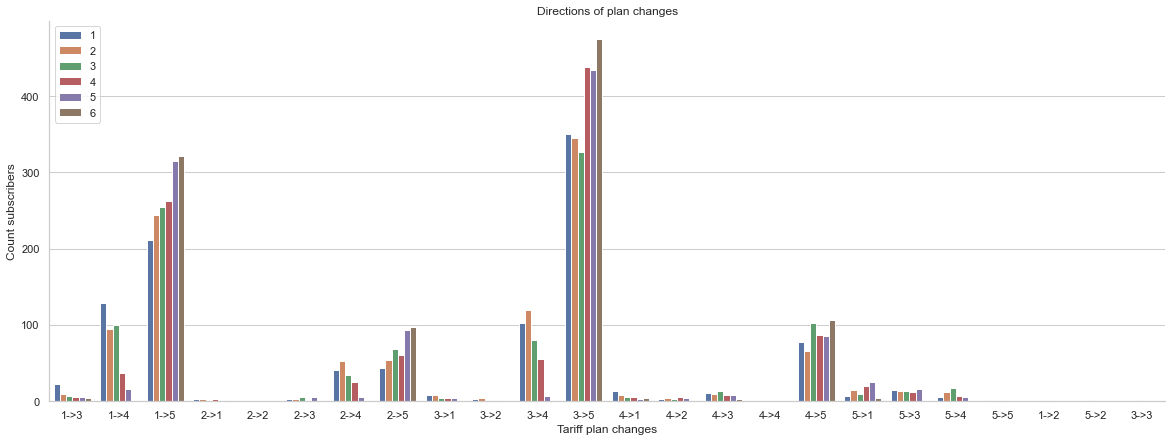

In [29]:
sns.set(rc={"figure.figsize":(20, 7)})
sns.set_style("whitegrid")
viz_flow_plans = sns.barplot(x='flow_end_start', y='count_SUBSCRIBERs', hue='month_flow', data=flow_plans_total)
viz_flow_plans.set_xlabel('Tariff plan changes')
viz_flow_plans.set_ylabel('Count subscribers')
viz_flow_plans.set_title('Directions of plan changes')
plt.legend(loc='upper left')
sns.despine()

Исходя из полученного графика можно сказать, что большие перетоки пользователей наблюдались с 1 на 5 т.п. и с 3 на 5 т.п.

**Насколько изменился среднемесячный счет абонентов за период 3 месяца после месяца смены тарифного плана в сравнении с периодом 3 месяца до месяца смены тарифного плана.**

Объединим датафрейм из предыдущего пункта и датафрейм charges с данными о платежах.

In [30]:
tariff_plans_charges = full_plans.merge(charges, how='left', on='SUBSCRIBER_ID')
tariff_plans_charges.head()

,SUBSCRIBER_ID,TARIFF_PLAN_ID_x,START_DTTM_x,END_DTTM_x,start_month,TARIFF_PLAN_ID_y,START_DTTM_y,END_DTTM_y,BILL_MONTH,CHARGES
0,1,3,2017-03-11,2017-07-01,2017-03-01,2,2013-11-22,2017-03-11,2016-12-01,21.132
1,1,3,2017-03-11,2017-07-01,2017-03-01,2,2013-11-22,2017-03-11,2017-10-01,20.464
2,1,3,2017-03-11,2017-07-01,2017-03-01,2,2013-11-22,2017-03-11,2017-06-01,23.651
3,1,3,2017-03-11,2017-07-01,2017-03-01,2,2013-11-22,2017-03-11,2016-09-01,24.964
4,1,3,2017-03-11,2017-07-01,2017-03-01,2,2013-11-22,2017-03-11,2017-09-01,24.012


In [31]:
# создадим столбец с названием потока смены тарифного плана
tariff_plans_charges['flow_end_start'] = tariff_plans_charges.TARIFF_PLAN_ID_y.astype(str) + '->' + tariff_plans_charges.TARIFF_PLAN_ID_x.astype(str)

In [32]:
# удалим ненужные колонки
tariff_plans_charges = tariff_plans_charges.drop(columns=['TARIFF_PLAN_ID_x', 'TARIFF_PLAN_ID_y', 'START_DTTM_x', 'END_DTTM_x', 
                                                         'START_DTTM_y', 'END_DTTM_y'])
tariff_plans_charges.head()

,SUBSCRIBER_ID,start_month,BILL_MONTH,CHARGES,flow_end_start
0,1,2017-03-01,2016-12-01,21.132,2->3
1,1,2017-03-01,2017-10-01,20.464,2->3
2,1,2017-03-01,2017-06-01,23.651,2->3
3,1,2017-03-01,2016-09-01,24.964,2->3
4,1,2017-03-01,2017-09-01,24.012,2->3


In [33]:
# создадим столбец с разницей в месяцах между началом смены тарифного плана и месяцем платежа
tariff_plans_charges['timedelta_month'] = ((tariff_plans_charges.start_month - tariff_plans_charges.BILL_MONTH)/np.timedelta64(1, 'M'))
tariff_plans_charges['timedelta_month'] = tariff_plans_charges['timedelta_month'].astype(int)

In [34]:
# сузим период для анализа данных до 4 месяцев, т.к. объединение датафреймов происходило только по SUBSCRIBER_ID, без даты
tariff_plans_charges = tariff_plans_charges.query("timedelta_month > -4 and timedelta_month < 4")\
    .drop(columns=['timedelta_month'])

In [35]:
tariff_plans_charges.dtypes

SUBSCRIBER_ID              int64
start_month       datetime64[ns]
BILL_MONTH        datetime64[ns]
CHARGES                  float64
flow_end_start            object
dtype: object

Аггрегируем датафрейм по пользователю и датам и рассчитаем средневзвешенные платежи

In [36]:
rolling_mean_total = tariff_plans_charges.groupby(['SUBSCRIBER_ID', 'start_month', 'BILL_MONTH']).agg({'CHARGES' : 'mean'})\
    .sort_values(['SUBSCRIBER_ID', 'start_month', 'BILL_MONTH']).rolling(3).mean().reset_index()
rolling_mean_total.head()

,SUBSCRIBER_ID,start_month,BILL_MONTH,CHARGES
0,1,2017-03-01,2016-11-01,NaN
1,1,2017-03-01,2016-12-01,NaN
2,1,2017-03-01,2017-01-01,21.258
3,1,2017-03-01,2017-02-01,23.086
4,1,2017-03-01,2017-03-01,25.262


In [37]:
# создадим столбец с разницей в месяцах между началом смены тарифного плана и месяцем платежа
rolling_mean_total['timedelta_month'] = ((rolling_mean_total.start_month - rolling_mean_total.BILL_MONTH)/np.timedelta64(1, 'M'))
rolling_mean_total['timedelta_month'] = rolling_mean_total['timedelta_month'].astype(int)

Аггрегируем датафрейм в разрезе месяца и периода смены тарифного плана.
<br> **-3** - 3 месяца после смены тарифного плана
<br> **1** - 3 месяца до смены тарифного плана

In [38]:
mean_charges = rolling_mean_total.query("timedelta_month in [1, -3]")\
    .groupby(['start_month', 'timedelta_month'], as_index=False).agg({'CHARGES' : 'mean'})
mean_charges.head()

,start_month,timedelta_month,CHARGES
0,2017-01-01,-3,6.289636
1,2017-01-01,1,8.185914
2,2017-02-01,-3,6.567241
3,2017-02-01,1,8.243824
4,2017-03-01,-3,6.663179


Визуализируем полученный результат

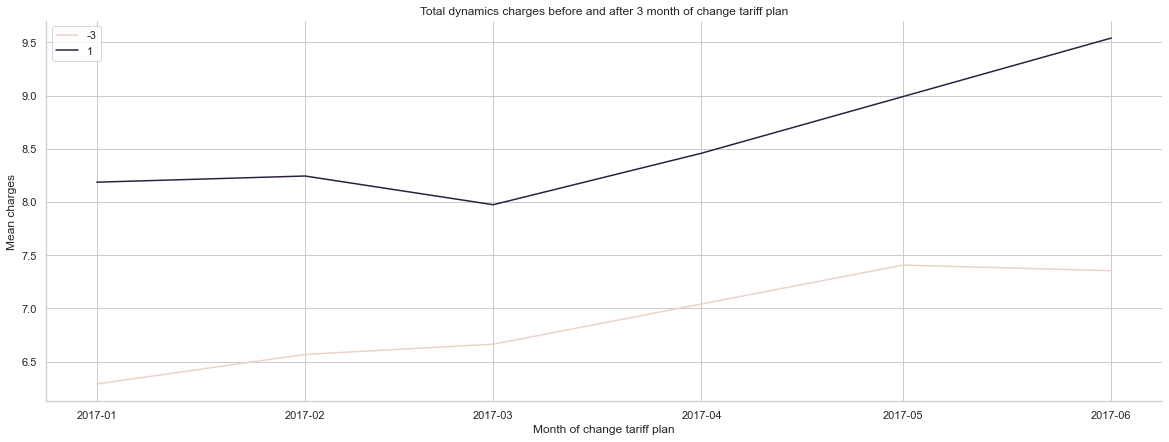

In [39]:
viz_mean_charges = sns.lineplot(x='start_month', y='CHARGES', hue='timedelta_month', data=mean_charges)
viz_mean_charges.set_xlabel('Month of change tariff plan')
viz_mean_charges.set_ylabel('Mean charges')
viz_mean_charges.set_title('Total dynamics charges before and after 3 month of change tariff plan')
plt.legend(loc='upper left')
sns.despine()

На графике мы можем видеть, что среднемесячный счет абонентов за период 3 месяца после месяца смены тарифного плана значительно снизился в сравнении с периодом 3 месяца до месяца смены тарифного плана.

**Какие направления смен тарифных планов характеризовались ростом среднего счета в трехмесячном периоде после месяца смены тарифного плана в сравнении с периодом 3 месяца до месяца смены тарифного плана, а какие – сокращением.**

Аггрегируем датафрейм по пользователю и потокам смены тарифного плана и рассчитаем средневзвешенные платежи

In [40]:
rolling_mean_flow = tariff_plans_charges.groupby(['SUBSCRIBER_ID', 'flow_end_start', 'start_month', 'BILL_MONTH'])\
    .agg({'CHARGES' : 'mean'})\
    .sort_values(['SUBSCRIBER_ID', 'flow_end_start', 'start_month', 'BILL_MONTH']).rolling(3).mean().reset_index()
rolling_mean_flow.head()

,SUBSCRIBER_ID,flow_end_start,start_month,BILL_MONTH,CHARGES
0,1,2->3,2017-03-01,2016-11-01,NaN
1,1,2->3,2017-03-01,2016-12-01,NaN
2,1,2->3,2017-03-01,2017-01-01,21.258
3,1,2->3,2017-03-01,2017-02-01,23.086
4,1,2->3,2017-03-01,2017-03-01,25.262


In [41]:
# создадим столбец с разницей в месяцах между началом смены тарифного плана и месяцем платежа
rolling_mean_flow['timedelta_month'] = ((rolling_mean_flow.start_month - rolling_mean_flow.BILL_MONTH)/np.timedelta64(1, 'M'))
rolling_mean_flow['timedelta_month'] = rolling_mean_flow['timedelta_month'].astype(int)

Аггрегируем датафрейм в разрезе потока и периода смены тарифного плана.
<br> **-3** - 3 месяца после смены тарифного плана
<br> **1** - 3 месяца до смены тарифного плана

In [42]:
mean_flow_charges = rolling_mean_flow.query("timedelta_month in [1, -3]")\
    .groupby(['flow_end_start', 'timedelta_month'], as_index=False).agg({'CHARGES' : 'mean'})\
    .sort_values(['flow_end_start', 'timedelta_month']).rename(columns={'CHARGES' : 'mean_charges'})
mean_flow_charges.head()

,flow_end_start,timedelta_month,mean_charges
0,1->2,-3,4.414583
1,1->2,1,5.131500
2,1->3,-3,9.503374
3,1->3,1,10.683430
4,1->4,-3,4.685629


Визуализируем полученный результат

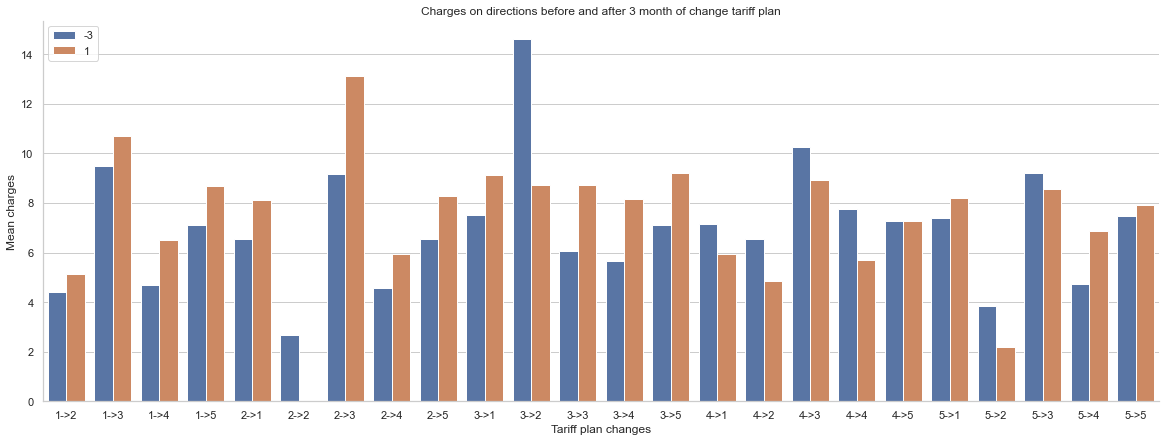

In [43]:
sns.set(rc={"figure.figsize":(20, 7)})
sns.set_style("whitegrid")
viz_mean_flow_charges = sns.barplot(x='flow_end_start', y='mean_charges', hue='timedelta_month', data=mean_flow_charges)
viz_mean_flow_charges.set_xlabel('Tariff plan changes')
viz_mean_flow_charges.set_ylabel('Mean charges')
viz_mean_flow_charges.set_title('Charges on directions before and after 3 month of change tariff plan')
plt.legend(loc='upper left')
sns.despine()

На графике мы можем видеть, что среднемесячный счет абонентов в разрезе потоков смены тарифных планов за период 3 месяца после месяца смены тарифного плана преимущественно снижался в сравнении с периодом 3 месяца до месяца смены тарифного плана. Рост наблюдался только для потоков 3->2, 4->3, 4->4 и 5->3.
<br>И это при том, что большие перетоки количества пользователей наблюдались по 1->5 и 3->5, по которым мы наблюдаем падение среднего счета.

**Насколько реже или чаще стали попадать в блокировки абоненты после миграции в целом и для каждого направления миграции в отдельности.**
<br>Для сравнения использовать те же периоды: 3 месяца до месяца смены плана и 3 месяца после месяца смены.

Объединим датафрейм из первого пункта и датафрейм suspended с данными о блокировках.

In [44]:
tariff_plans_suspended = full_plans.merge(suspended, how='left', on='SUBSCRIBER_ID')\
    .dropna(subset=['TARIFF_PLAN_ID_y'])
tariff_plans_suspended.head()

,SUBSCRIBER_ID,TARIFF_PLAN_ID_x,START_DTTM_x,END_DTTM_x,start_month,TARIFF_PLAN_ID_y,START_DTTM_y,END_DTTM_y,START_DT,END_DT,STATUS
0,1,3,2017-03-11,2017-07-01,2017-03-01,2,2013-11-22,2017-03-11,NaT,NaT,NaN
1,2,5,2017-06-29,2017-07-01,2017-06-01,1,2016-02-05,2017-06-29,NaT,NaT,NaN
2,3,5,2017-04-14,2017-07-01,2017-04-01,1,2015-05-06,2017-04-14,NaT,NaT,NaN
3,4,5,2017-01-09,2017-07-01,2017-01-01,3,2016-01-27,2017-01-09,NaT,NaT,NaN
4,5,5,2017-05-08,2017-07-01,2017-05-01,1,2016-02-06,2017-05-08,2017-07-31,2017-08-14,Suspended


In [45]:
# конвертируем данные в int64, где необходимо 
tariff_plans_suspended['TARIFF_PLAN_ID_y'] = tariff_plans_suspended.TARIFF_PLAN_ID_y.astype('int64')
tariff_plans_suspended['TARIFF_PLAN_ID_x'] = tariff_plans_suspended.TARIFF_PLAN_ID_x.astype('int64')

In [46]:
# создадим столбец с названием потока смены тарифного плана
tariff_plans_suspended['flow_end_start'] = tariff_plans_suspended.TARIFF_PLAN_ID_y.astype(str) + '->' + tariff_plans_suspended.TARIFF_PLAN_ID_x.astype(str)

In [47]:
# удалим ненужные колонки
tariff_plans_suspended = tariff_plans_suspended.drop(columns=['TARIFF_PLAN_ID_x', 'TARIFF_PLAN_ID_y', 'START_DTTM_x', 'END_DTTM_x', 
                                                         'START_DTTM_y', 'END_DTTM_y'])
tariff_plans_suspended.head()

,SUBSCRIBER_ID,start_month,START_DT,END_DT,STATUS,flow_end_start
0,1,2017-03-01,NaT,NaT,NaN,2->3
1,2,2017-06-01,NaT,NaT,NaN,1->5
2,3,2017-04-01,NaT,NaT,NaN,1->5
3,4,2017-01-01,NaT,NaT,NaN,3->5
4,5,2017-05-01,2017-07-31,2017-08-14,Suspended,1->5


In [48]:
# проверим данные на пропущенные значения
tariff_plans_suspended.isna().sum()

SUBSCRIBER_ID        0
start_month          0
START_DT          5041
END_DT            5041
STATUS            5041
flow_end_start       0
dtype: int64

Приведем данные по дате блокировки пользователя к началу месяца.

In [49]:
tariff_plans_suspended['start_month_suspended'] = pd.to_datetime(tariff_plans_suspended.START_DT).dt.to_period('M').dt.to_timestamp()

Заполним пустые значения по столбу STATUS на значение 'Not Suspended'

In [50]:
tariff_plans_suspended['STATUS'] = tariff_plans_suspended.STATUS.fillna('Not Suspended')

In [51]:
tariff_plans_suspended.head()

,SUBSCRIBER_ID,start_month,START_DT,END_DT,STATUS,flow_end_start,start_month_suspended
0,1,2017-03-01,NaT,NaT,Not Suspended,2->3,NaT
1,2,2017-06-01,NaT,NaT,Not Suspended,1->5,NaT
2,3,2017-04-01,NaT,NaT,Not Suspended,1->5,NaT
3,4,2017-01-01,NaT,NaT,Not Suspended,3->5,NaT
4,5,2017-05-01,2017-07-31,2017-08-14,Suspended,1->5,2017-07-01


In [52]:
# проверим типы данных
tariff_plans_suspended.dtypes

SUBSCRIBER_ID                     int64
start_month              datetime64[ns]
START_DT                 datetime64[ns]
END_DT                   datetime64[ns]
STATUS                           object
flow_end_start                   object
start_month_suspended    datetime64[ns]
dtype: object

Аггрегируем датафрейм по месяцу смены ТП и месяцу блокировки

In [53]:
rolling_tariff_plans_suspended = tariff_plans_suspended\
        .groupby(['start_month', 'start_month_suspended'])\
        .agg({'SUBSCRIBER_ID' : 'nunique'}).sort_values(['start_month', 'start_month_suspended'])\
        .rename(columns={'SUBSCRIBER_ID' : 'mean_counts'})\
        .rolling(3).mean().reset_index()
rolling_tariff_plans_suspended.head()

,start_month,start_month_suspended,mean_counts
0,2017-01-01,2016-06-01,NaN
1,2017-01-01,2016-07-01,NaN
2,2017-01-01,2016-08-01,34.666667
3,2017-01-01,2016-09-01,32.000000
4,2017-01-01,2016-10-01,36.666667


Создадим столбец с разницей в месяцах между началом смены тарифного плана и месяцем блокировки

In [54]:
rolling_tariff_plans_suspended['timedelta_month'] = ((rolling_tariff_plans_suspended.start_month - rolling_tariff_plans_suspended.start_month_suspended)/np.timedelta64(1, 'M'))
rolling_tariff_plans_suspended['timedelta_month'] = rolling_tariff_plans_suspended['timedelta_month'].astype(int)

Аггрегируем датафрейм в разрезе месяца смены ТП и периода смены тарифного плана.
<br> **-3** - 3 месяца после смены тарифного плана
<br> **1** - 3 месяца до смены тарифного плана

In [55]:
mean_suspended = rolling_tariff_plans_suspended.query("timedelta_month in [1, -3]")\
    .groupby(['start_month', 'timedelta_month'], as_index=False).agg({'mean_counts' : 'mean'})
mean_suspended.head()

,start_month,timedelta_month,mean_counts
0,2017-01-01,-3,38.000000
1,2017-01-01,1,43.333333
2,2017-02-01,-3,35.333333
3,2017-02-01,1,50.333333
4,2017-03-01,-3,39.000000


Визуализируем полученные данные

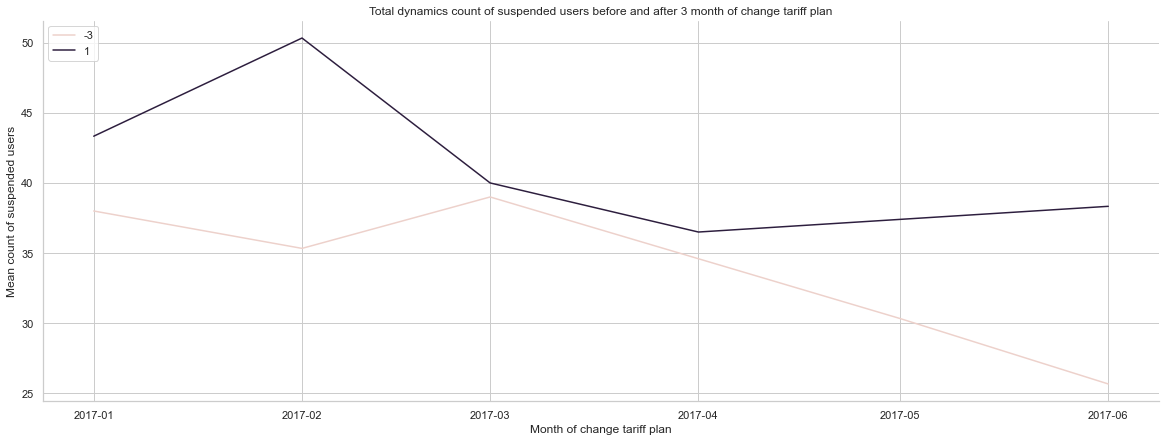

In [56]:
viz_mean_suspended = sns.lineplot(x='start_month', y='mean_counts', hue='timedelta_month', data=mean_suspended)
viz_mean_suspended.set_xlabel('Month of change tariff plan')
viz_mean_suspended.set_ylabel('Mean count of suspended users')
viz_mean_suspended.set_title('Total dynamics count of suspended users before and after 3 month of change tariff plan')
plt.legend(loc='upper left')
sns.despine()

Анализируя динамику блокировок, можно отметить, что количество заблокированных абонентов за период 3 месяца после месяца смены тарифного плана значительно снизился в сравнении с периодом 3 месяца до месяца смены тарифного плана.

**Насколько реже или чаще стали попадать в блокировки абоненты после миграции для каждого направления миграции.**

Сгруппируем данные по направлению потоков смены тарифных планов по месяцам.

In [57]:
suspended_flow = tariff_plans_suspended.groupby(['flow_end_start', 'start_month', 'start_month_suspended'])\
    .agg({'SUBSCRIBER_ID' : 'nunique'})\
    .sort_values(['flow_end_start', 'start_month', 'start_month_suspended']).rolling(3).mean().reset_index()\
    .rename(columns={'SUBSCRIBER_ID' : 'mean_count'})
suspended_flow.head()

,flow_end_start,start_month,start_month_suspended,mean_count
0,1->2,2017-03-01,2017-03-01,NaN
1,1->2,2017-04-01,2017-04-01,NaN
2,1->3,2017-01-01,2016-09-01,1.0
3,1->3,2017-02-01,2016-08-01,1.0
4,1->3,2017-02-01,2016-11-01,1.0


In [58]:
# создадим столбец с разницей в месяцах между началом смены тарифного плана и месяцем платежа
suspended_flow['timedelta_month'] = ((suspended_flow.start_month - suspended_flow.start_month_suspended)/np.timedelta64(1, 'M'))
suspended_flow['timedelta_month'] = suspended_flow['timedelta_month'].astype(int)

Аггрегируем датафрейм в разрезе потока смена ТП и периода блокировки.
<br> **-3** - 3 месяца после смены тарифного плана
<br> **1** - 3 месяца до смены тарифного плана

In [59]:
mean_suspended_flow = suspended_flow.query("timedelta_month in [1, -3]")\
    .groupby(['flow_end_start', 'timedelta_month'], as_index=False).agg({'mean_count' : 'mean'})
mean_suspended_flow.head()

,flow_end_start,timedelta_month,mean_count
0,1->3,1,1.000000
1,1->4,-3,4.666667
2,1->4,1,4.933333
3,1->5,-3,6.000000
4,1->5,1,7.111111


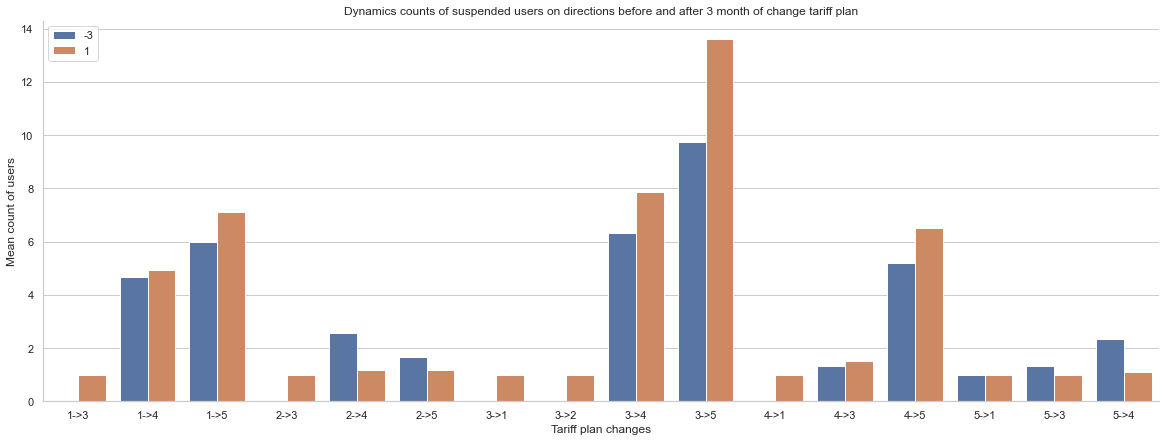

In [60]:
sns.set(rc={"figure.figsize":(20, 7)})
sns.set_style("whitegrid")
viz_mean_suspended_flow = sns.barplot(x='flow_end_start', y='mean_count', hue='timedelta_month', data=mean_suspended_flow)
viz_mean_suspended_flow.set_xlabel('Tariff plan changes')
viz_mean_suspended_flow.set_ylabel('Mean count of users')
viz_mean_suspended_flow.set_title('Dynamics counts of suspended users on directions before and after 3 month of change tariff plan')
plt.legend(loc='upper left')
sns.despine()

На графике мы можем видеть, что среднее количество заблокированных абонентов за период 3 месяца после месяца смены тарифного плана преимущественно снижалось в сравнении с периодом 3 месяца до месяца смены тарифного плана.
<br>Рост наблюдался только для потоков 2->4, 5->4 и 5->3.